# C-vine Copula Trading Strategy

This notebook demonstrates the essential usage of the `vinecop_generate` and `vinecop_strategy` module.
The strategy is an implementation of

* [Statistical Arbitrage with Vine Copulas(2016)](https://www.iwf.rw.fau.de/files/2015/12/11-2016-1.pdf)

**Note**: the literature above only utilizes C-vine copula, instead of D-vine or more general R-vine.

## C-vine Copula Overview

Vine copula is created to address the problem of modeling the dependencies of multiple random variables.
Instead of using an N-dimensional copula directly, it decomposes the probability density into conditional probabilities, and further decomposes conditional probabilities into bivariate copulas.
To sum up, **the idea is that we decompose the high dimensional pdf into bivariate copulas densities and marginal densities**.

For example, for 3 random variables we decompose the joint density $f(x_1, x_2, x_3)$ as follows:

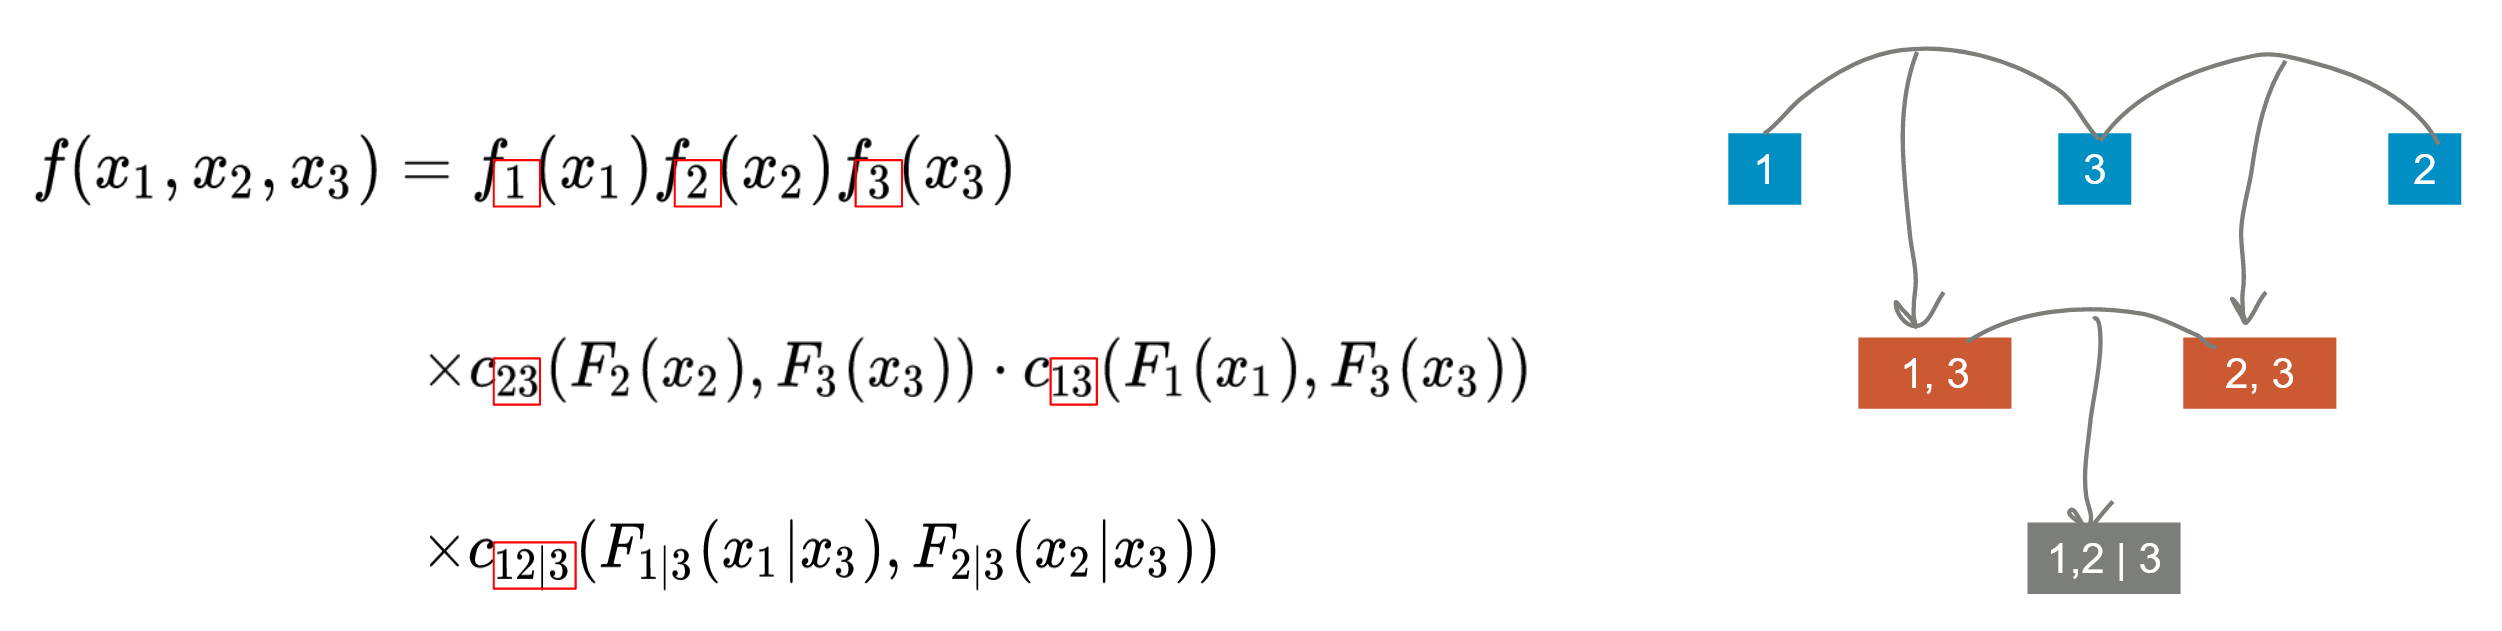

In [1]:
from IPython.display import Image
Image(filename='images/3d_vinecop_decomposition.png')

where $f_i(x_i)$ is the marginal density for random variable $X_i$ and $c_{ij}$ is the bivariate copula for random variable $X_i$ and $X_j$ linking the density of $f_i, f_j$, and $c_{ij|k}$ is the bivariate copula that links the density of $c_{ik}, c_{jk}$.

This tree structure classifies the type of vine copula: each node stands for a density, either a joint density computed from a copula or a marginal density.
The most generic stricture is the R-vine (Regular-vine), and the tree must satisfy the following conditions:

1. For $N$ many random variables there are $N$ levels in the tree, with level $i (i = 1,\cdots, N)$ having $N-i+1$ nodes.
2. Proximity condition: every edge between 2 nodes contributes to a joint density node in the next level.
3. Every layer must be a connected graph, and the edge number must be 1 less than the node number.

C-vine (Canonical-vine) and D-vine (Drawable-vine) are special cases for an R-vine, and they are the most often used models in applications due to interpretability.
C-vine requires that, at every level of the tree, there must be a **center node** that connects to every other nodes.
D-vine requires that, every level of the tree is a **path**, i.e., all the nodes are chained like a 1-D linked list.
See below for a visual explanation.

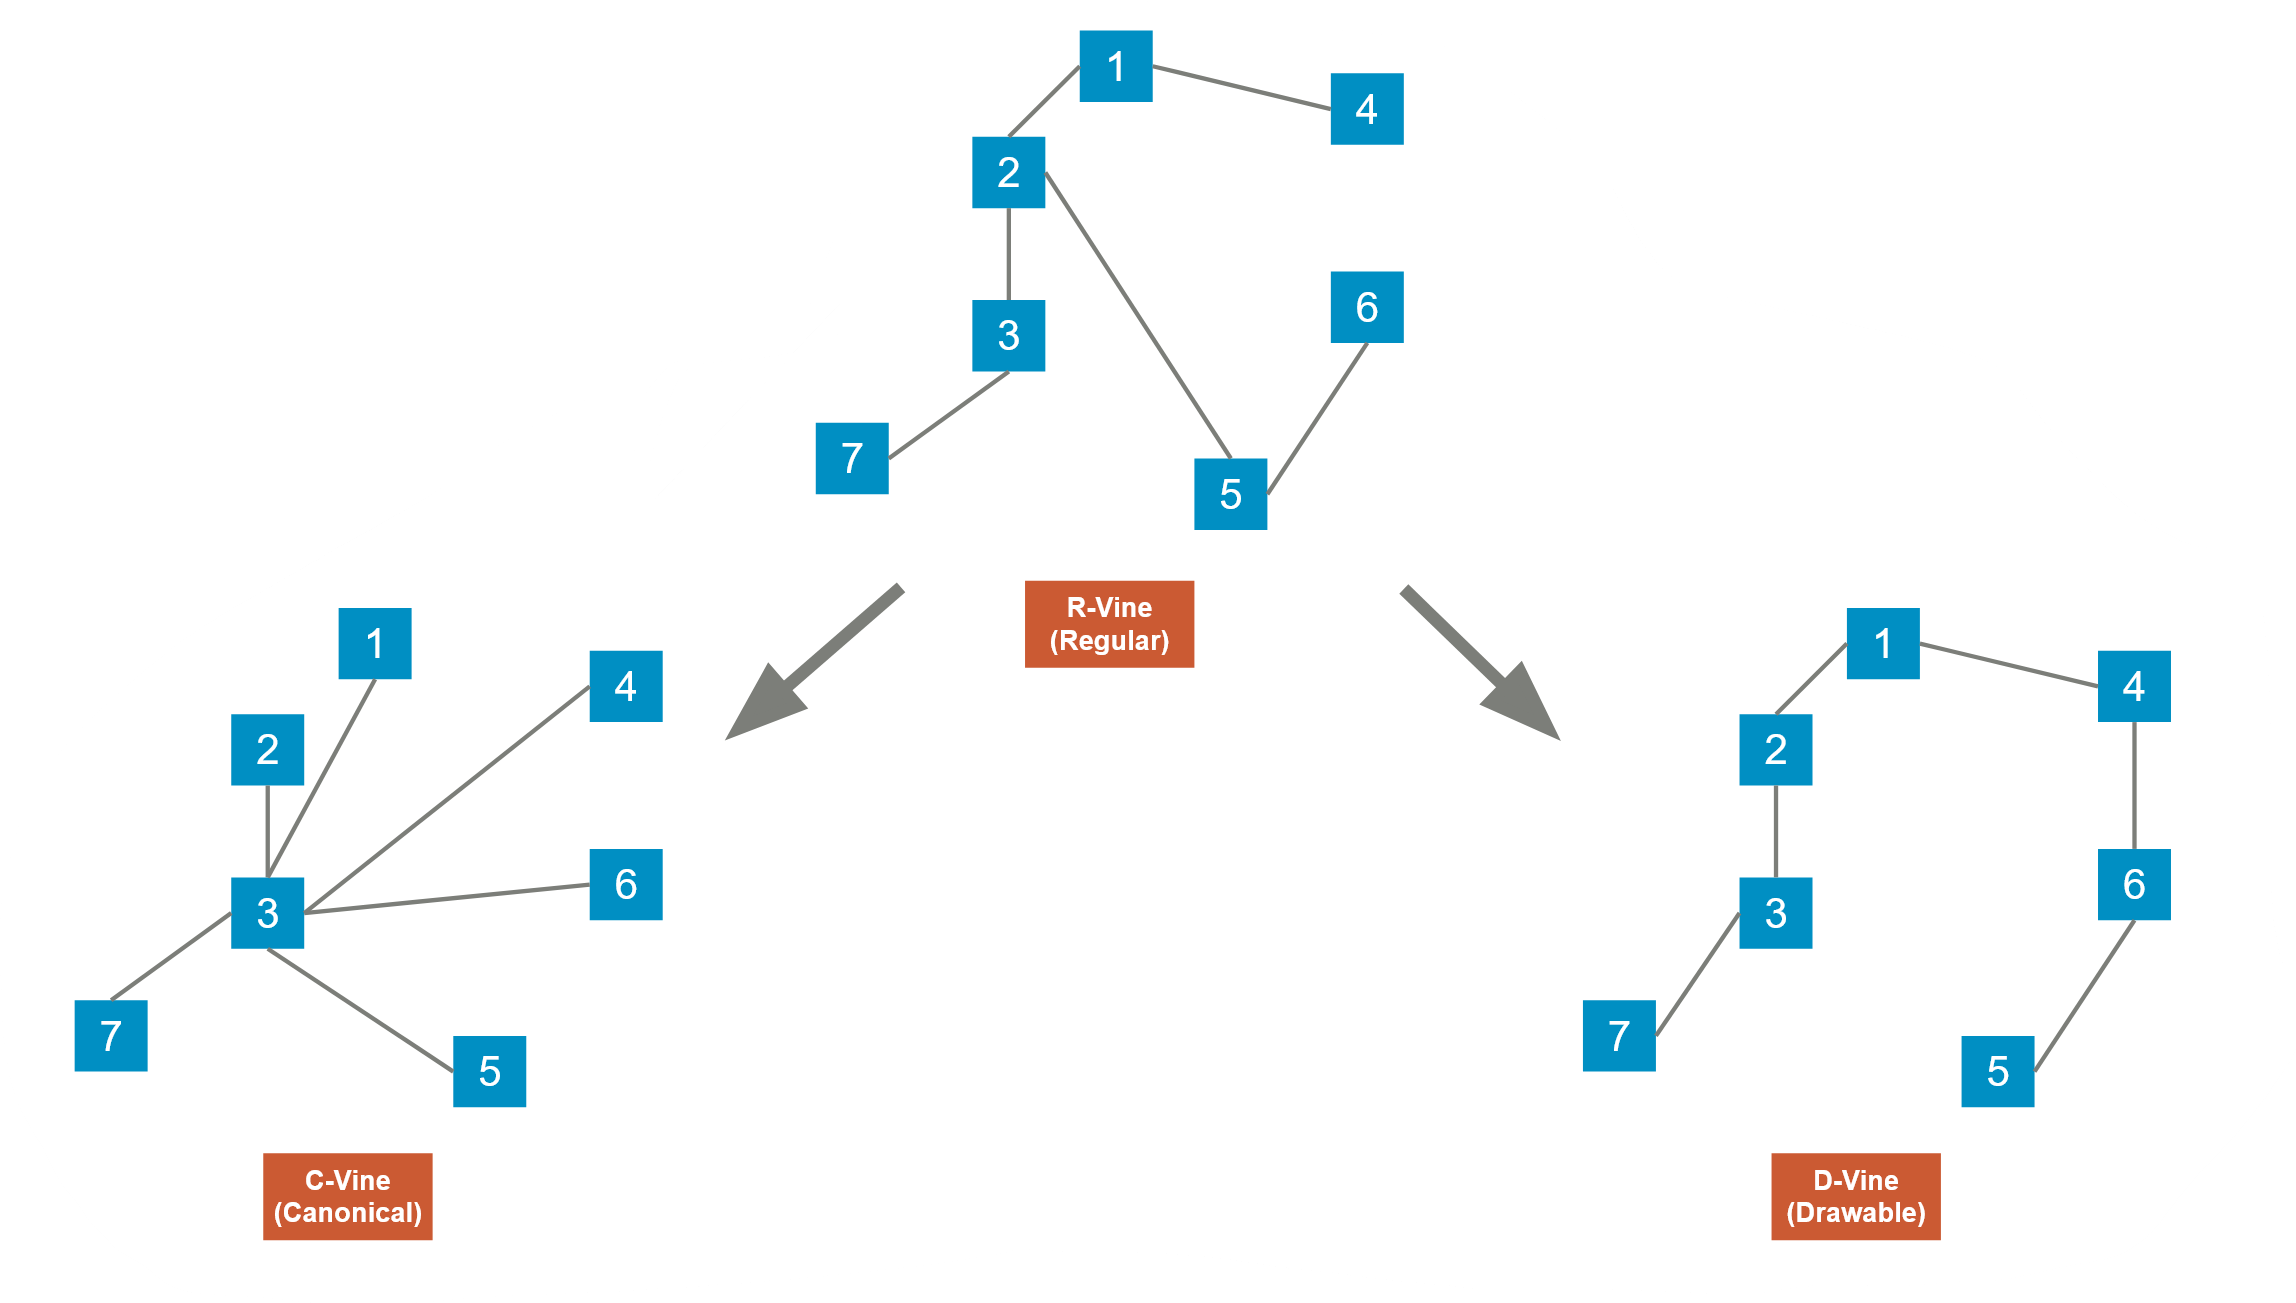

In [2]:
Image(filename='images/Rvine_Cvine_Dvine.png')

The advantage of using a C-vine comes from the trading strategy: At first we choose a cohort of stocks, say 4 of them.
Within the cohort there exists a target stock, and the long/short signals are generated with respect to this target stock.
Hence the C-vine model that highlights a governing component at each level of the tree is a natural choice.

We will not dive further into the mathematics of vine copula and we now move onto the key ideas of the trading strategy.
The take-home message is that, **vine copula is a powerful tool to generate mispricing info through probability for a stock, when compared to other stocks**.
Interested readers can check the documentation which has a nice summary of all the key concepts, or check the landmark paper [Selecting and estimating regular vine copulae and application to financial returns](https://arxiv.org/pdf/1202.2002).

## Workflow and the Strategy

To sum up, the workflow is as follows:

1. Select stocks cohorts, and translate into pseudo-observations.
2. Fit to data to figure out the C-vine structure.
3. Calculate conditional cumulative densities from joint probability densities, and then formulate mispricing index and cumulative mispricing index (CMPI).
4. Formlate signals and trade based on Bollingerband of CMPI.

We discuss briefly what each part means in application.
We also exclusively use stocks daily returns for our data.

### 1. Select stocks and translate into pseudo-observations.
Selecting trading candidates is a serious topic, and can largely determine if a strategy is profitable or not.
There are 4 methods proposed in [Stübinger et al. 2018]: pairwise Spearman's rho, multi-dimensional Spearman's rho, sum of distance in quantile plots to hyper-diagonal, and a copula-chi-square test for dependence.
Loosely speaking, the goal is to find stocks cohorts that are heavily dependent, such that a mean-reversion bet on relative mispricings is profitable.
For more details in implementation, please refer to `vine_copula_partner_selection.ipynb`.

After choosing a collection of cohorts and their corresponding target stocks, we split the returns data into training and trading subsets.
We map the training data into their corresponding quantiles (pseudo-observations) using empirical CDFs (ECDFs).




In [3]:
import arbitragelab.copula_approach.vinecop_generate as vinecop_generate
import arbitragelab.copula_approach.vinecop_strategy as vinecop_strategy
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from arbitragelab.copula_approach.vine_copula_partner_selection import PartnerSelection
from arbitragelab.copula_approach.copula_calculation import to_quantile
# import arbitragelab.util.data_importer as data_importer

In [4]:
# Import data
sp500_prices = pd.read_csv('./prices_10y_SP500.csv',
                           index_col=0, parse_dates=True).fillna(method='ffill')
sp500_returns = sp500_prices.pct_change().fillna(0)

# Training and testing split
returns_train = sp500_returns.iloc[:800].drop(columns='SPY')
returns_test = sp500_returns.iloc[800:1200].drop(columns='SPY')

prices_spy_test = sp500_prices['SPY'].iloc[800:1200]

#### Partner selection
Use the extended approach to select 10 cohorts. The 1st stock in each cohort is the target stock:

for example, `A` is the target stock for the cohort `[[A, PKI, TMO, MTD]]`.

In [5]:
# Intantiate a partner selection module and use the extended approach (multi dimensional Spearman's rho)
ps = PartnerSelection(returns_train)
extended_Q = ps.extended(10)
print(pd.Series(extended_Q))
# For time sake, we will only use the first 4 cohorts to demonstrate the trading module
cohorts = extended_Q[:4]

# Alternatively you can use the following methods. Uncomment to use them
# traditional_Q = ps.traditional(10)
# extended_Q = ps.extended(10)
# extremal_Q = ps.extremal(10)

0           [A, PKI, TMO, MTD]
1         [AAL, LUV, UAL, ALK]
2          [AAP, AMP, AIZ, GL]
3    [AAPL, GOOGL, GOOG, FFIV]
4          [ABC, UNM, GL, PRU]
5          [ABMD, AFL, L, UNM]
6         [ABT, SLG, SPG, BXP]
7       [ACN, PAYX, FISV, ADP]
8        [ADBE, LNC, PFG, IVZ]
9      [ADI, MCHP, MXIM, XLNX]
dtype: object


In [6]:
# Translate the returns into quantiles data for the cohorts
# All the tickers we are interested in
all_tickers = list(set(ticker for cohort in cohorts for ticker in cohort))
subset_rts_train = returns_train[all_tickers]
subset_rts_test = returns_test[all_tickers]

# Train the ECDF and get the quantiles data for the training set
subset_quantiles_train, cdfs = to_quantile(subset_rts_train)
# Also get the numerical index for tickers in each cohort for the data set
num_cohorts_idx = []
cdfs_cohorts = []
for cohort in cohorts:
    num_cohort_idx = [subset_rts_train.columns.get_loc(ticker) for ticker in cohort]
    num_cohorts_idx.append(num_cohort_idx)
    cdfs_cohort = [cdfs[idx] for idx in num_cohort_idx]
    cdfs_cohorts.append(cdfs_cohort)
print(num_cohorts_idx)

[[9, 12, 15, 0], [14, 4, 7, 1], [6, 13, 10, 5], [2, 3, 8, 11]]


### 2. Fit C-vine copulas for each of the cohorts

We need the quantiles data and a target stock index to fit a C-vine copula.
Here the target stock index is indexed from 1, not 0. It indicates in the DataFrame `data`, which one is the target stock.

You can also print out the tree structure for the i-th cohort's vine copula by

`print(structures[i])`

In [7]:
# Fit C-vine copulas, this is slow.
cvinecops = []
structures = []
for cohort_number, cohort in enumerate(cohorts):
    quantiles_data_train = subset_quantiles_train[cohort]
    cvinecop = vinecop_generate.CVineCop()
    structure = cvinecop.fit_auto(data=quantiles_data_train, pv_target_idx=1, if_renew=True)
    
    cvinecops.append(cvinecop)
    structures.append(structure)

### 3. Formulate CMPIs using the trading class

Mispricing index (MPI) are just conditional cumulative probabilities, which can be calculated directly from the vine copula by numerical integration.
Cumulative mispricing index (CMPI) is the de-meaned sum of MPIs, i.e.,

`CMPIs = (MPIs - 0.5).cumsum()`

CMPI is used to determine whether the target stock is overpriced or underpriced compared to other stocks in the cohort.
CMPIs should be resonably similar in shape to cumulative log returns.
This can be used as a sanity check on whether our model fit makes sense.

In [8]:
# Calculate CMPIs
mpis_cohorts = []
cmpis_cohorts = []
cvcss = []
for cohort_number, cohort in enumerate(cohorts):
    # Initiate the trading class
    cvcs = vinecop_strategy.CVineCopStrat(cvinecops[cohort_number])
    cvcss.append(cvcs)
    # Calculate MPIs for the trading period
    mpis_trading = cvcs.calc_mpi(returns=subset_rts_test[cohort], cdfs=cdfs_cohorts[cohort_number],
                                 subtract_mean=True)
    mpis_cohorts.append(mpis_trading)
    
    cmpis_trading = mpis_trading.cumsum()
    cmpis_cohorts.append(cmpis_trading)

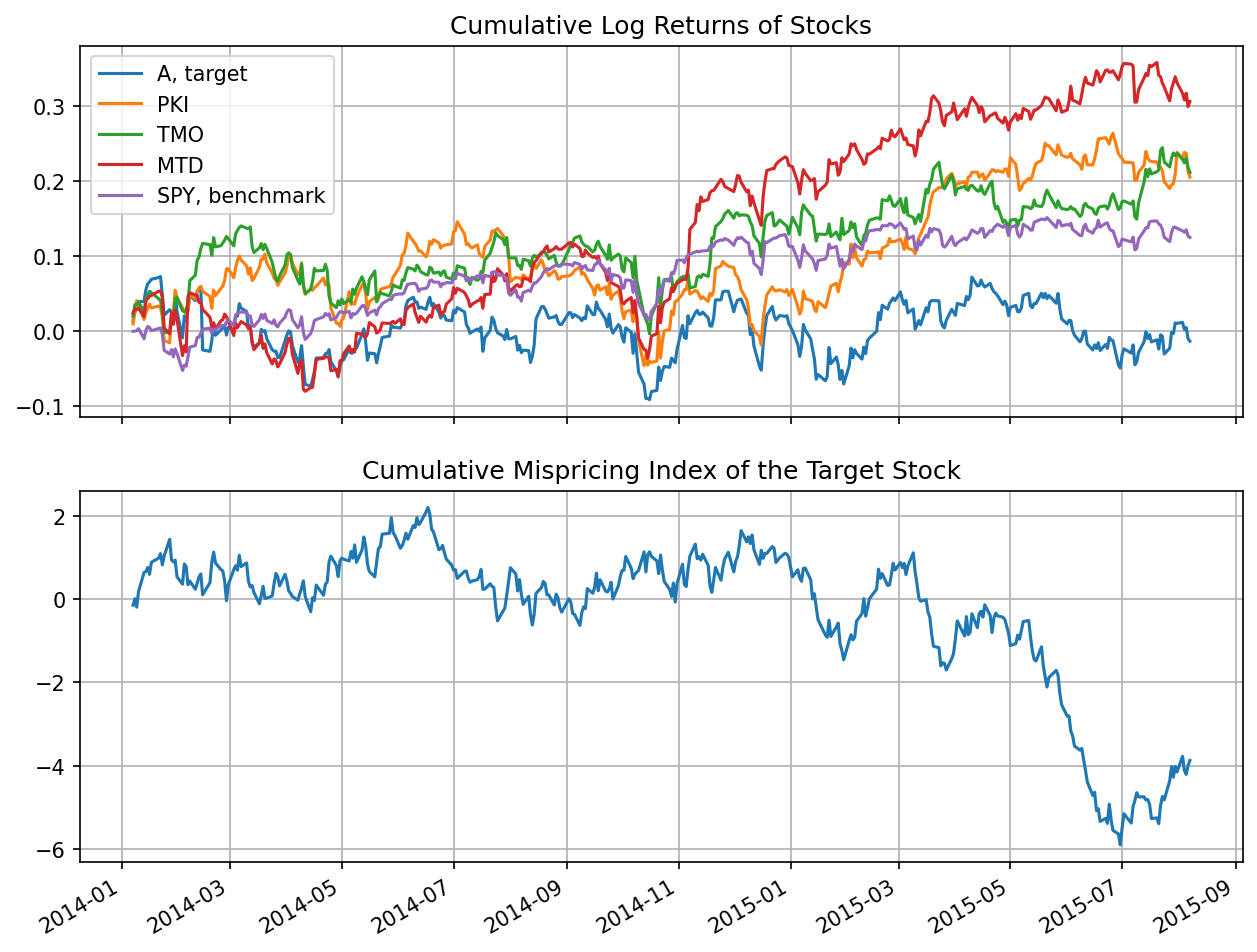

In [9]:
# For cohort 0, plot the cmpis against the log prices for the trading period
sum_log_returns = (subset_rts_test + 1).apply(np.log, axis=0).cumsum()

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(10,8), dpi=150)

axs[0].set_title('Cumulative Log Returns of Stocks')
axs[0].plot(sum_log_returns['A'], label='A, target')
axs[0].plot(sum_log_returns['PKI'], label='PKI')
axs[0].plot(sum_log_returns['TMO'], label='TMO')
axs[0].plot(sum_log_returns['MTD'], label='MTD')
axs[0].plot(np.log(prices_spy_test) - np.log(prices_spy_test)[0], label='SPY, benchmark')
axs[0].plot()
axs[0].grid()
axs[0].legend()

axs[1].set_title('Cumulative Mispricing Index of the Target Stock')
axs[1].plot(cmpis_cohorts[0], label='CMPI')
axs[1].grid()

fig.autofmt_xdate()

plt.show()

**Spoiler**: this is only the cohort that ends up losing money in the final equity curve check.
The reason may come from that all the 4 stocks are not behaving like the SPY at all.
Hence when traded against SPY the method falls apart.
This may be a valid place for potential improvements of the strategy.

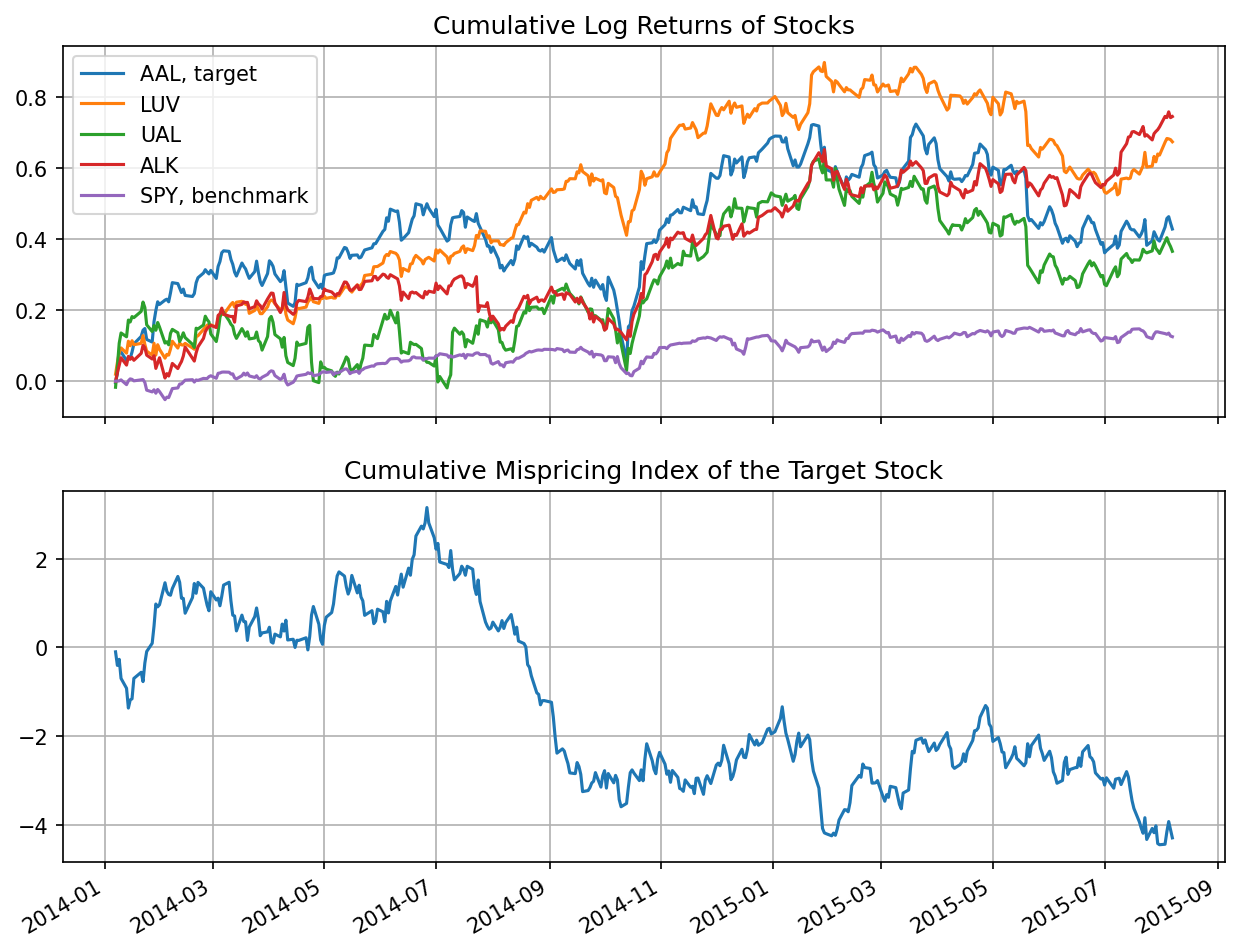

In [10]:
# For cohort 1, plot the cmpis against the log prices for the trading period

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(10,8), dpi=150)

axs[0].set_title('Cumulative Log Returns of Stocks')
axs[0].plot(sum_log_returns['AAL'], label='AAL, target')
axs[0].plot(sum_log_returns['LUV'], label='LUV')
axs[0].plot(sum_log_returns['UAL'], label='UAL')
axs[0].plot(sum_log_returns['ALK'], label='ALK')
axs[0].plot(np.log(prices_spy_test) - np.log(prices_spy_test)[0], label='SPY, benchmark')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Cumulative Mispricing Index of the Target Stock')
axs[1].plot(cmpis_cohorts[1], label='CMPI')
axs[1].grid()

fig.autofmt_xdate()

plt.show()

### 4. Trade using Bollinger band

The trading scheme follows a dollar neutral strategy: if the position is long, then we long 1/2 dollar the target stock and short accordingly 1/2 dollar SPY, and vice versa for short positions.

The Bollinger band is just a fixed length moving average of CMPI, together with upper limit and lower limit determined by a constant multiplied by moving standard deviations.
Signal is generated as follows:

* When the CMPI > upper limit of the Bollinger band, Short
* When the CMPI < lower limit of the Bollinger band, Long
* When the CMPI crosses with the moving average, Exit
* Else, Do nothing

See below for an example:

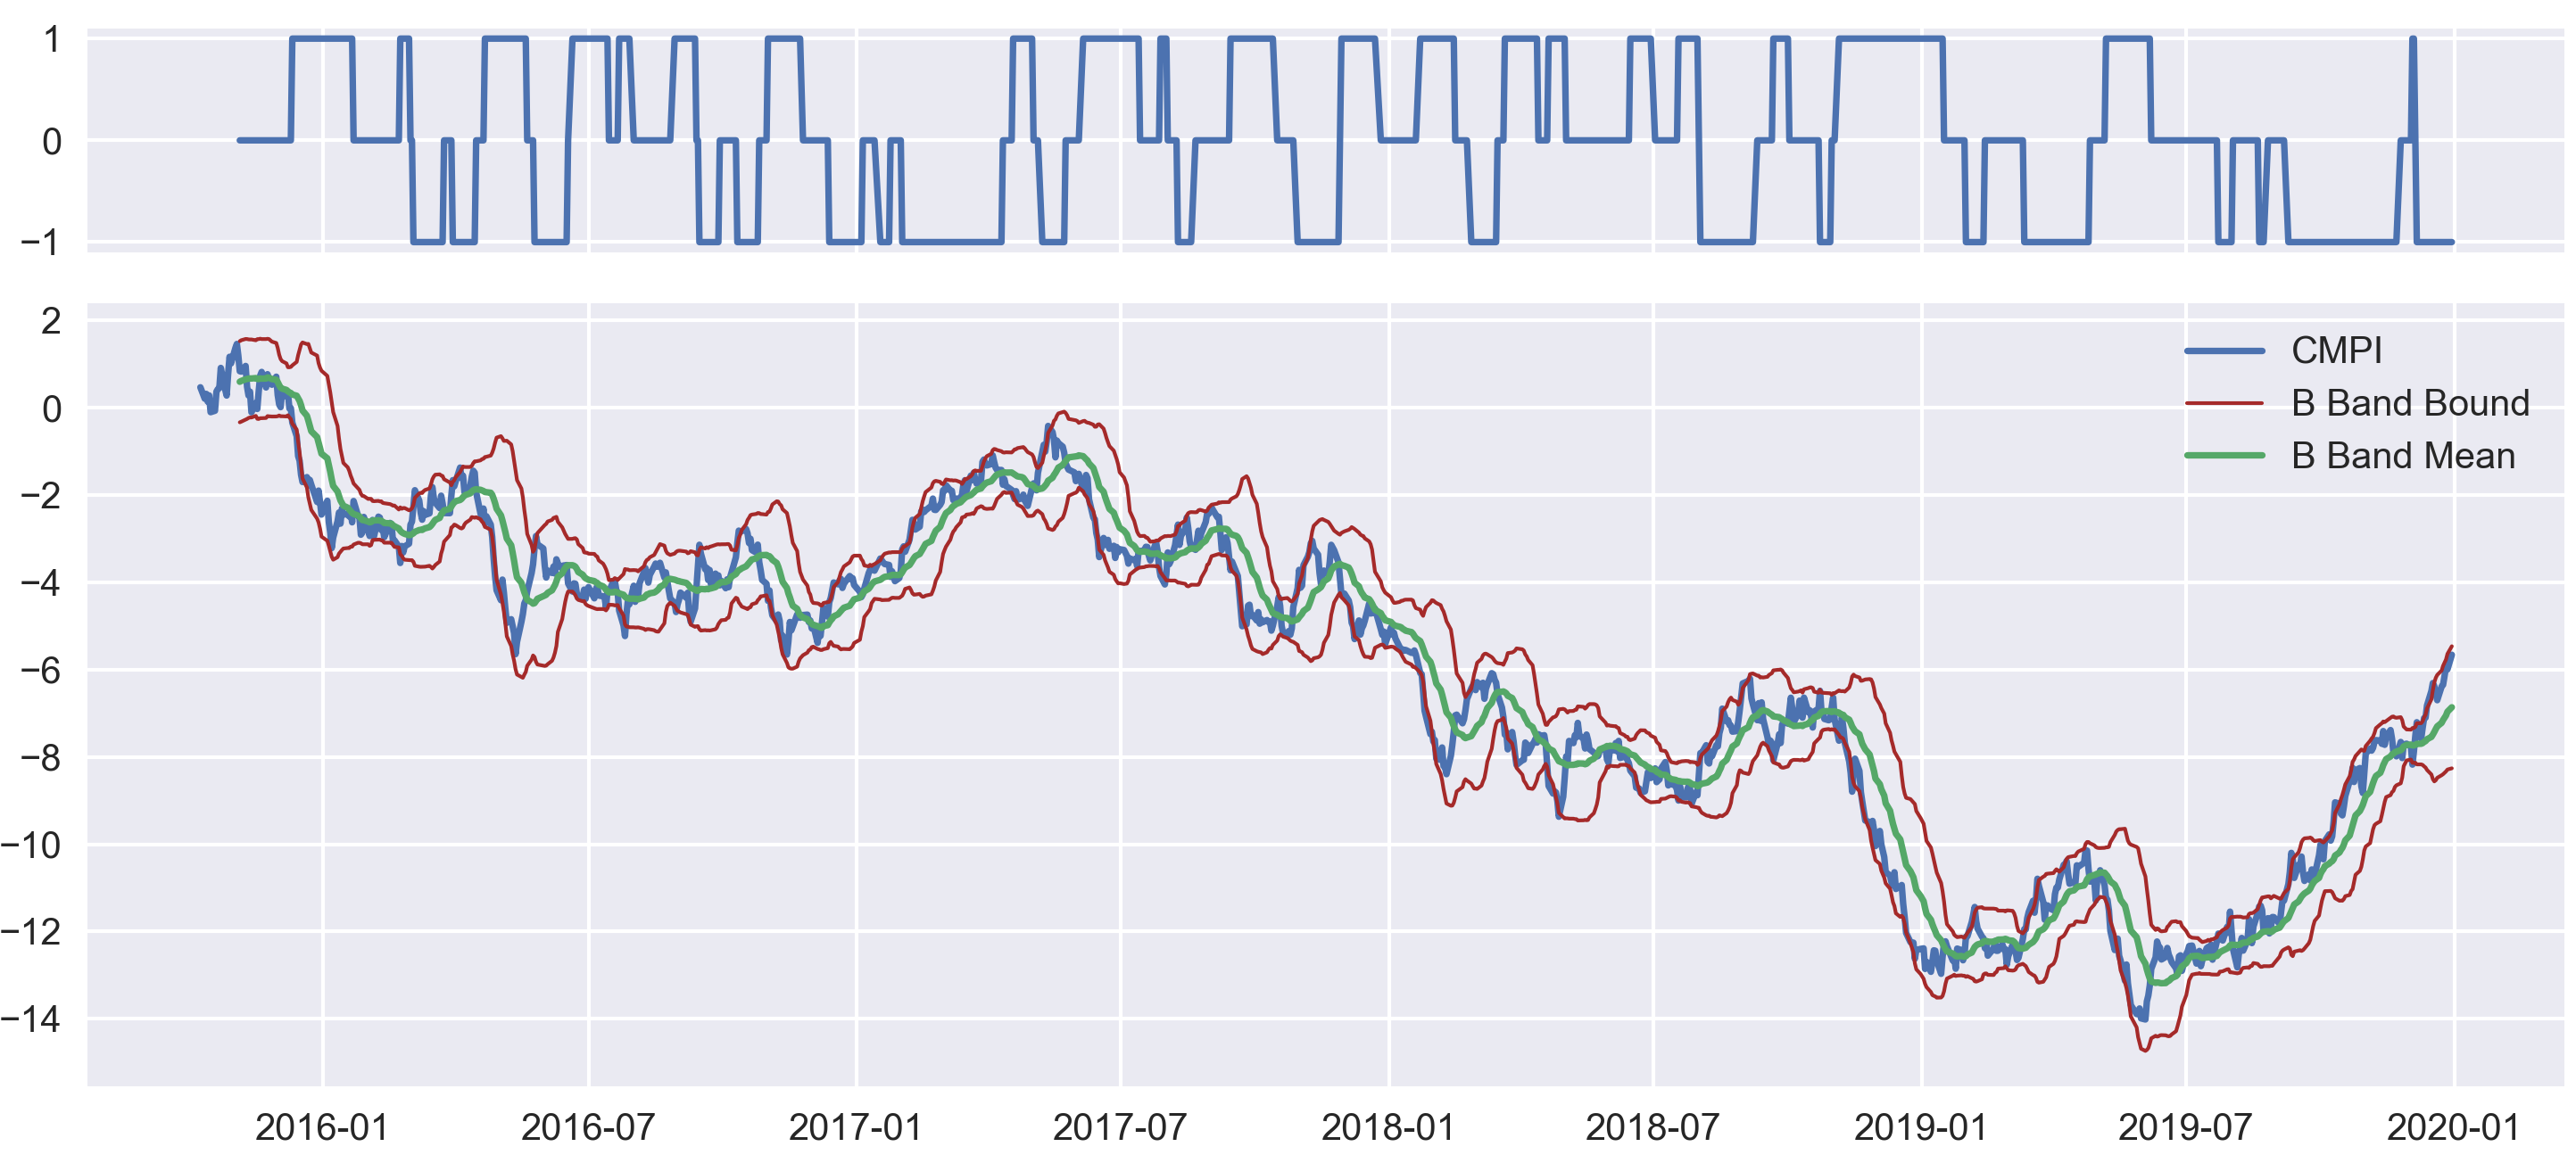

In [14]:
Image(filename='images/Bollinger_band_example.png')

In [11]:
# We now calculate positions, bollinger band and units for all of the cohorts
positions_cohorts = []
bband_cohorts = []
units_cohorts = []
for cohort_number, cohort in enumerate(cohorts):
    positions, bollinger_band = cvcss[cohort_number].get_positions_bollinger(
        returns=subset_rts_test[cohort], cdfs=cdfs_cohorts[cohort_number],
        mpis=mpis_cohorts[cohort_number]+0.5, if_return_bollinger_band=True, threshold_std=2)
    
    units = cvcss[cohort_number].positions_to_units_against_index(
        target_stock_prices=sp500_prices[cohort[0]][800:1200],
        index_prices=prices_spy_test,
        positions=positions.shift(1),
        multiplier=200)
    
    positions_cohorts.append(positions)
    bband_cohorts.append(bollinger_band)
    units_cohorts.append(units)

### 5. Calcluate portfolio P&L and equity curve

Now for all cohorts we calculate the daily P&L, and their equity curve.
Then we total together to get the sum.
We expect the risk shrinks as the number of cohorts increases due to diversification.

In [12]:
equity_cohorts = []
for cohort_number, cohort in enumerate(cohorts):
    portfolio_pnl = subset_rts_test[cohort[0]] * units_cohorts[cohort_number][cohort[0]] \
                  + sp500_returns['SPY'][800:1200] * units_cohorts[cohort_number]['SPY']
    equity = portfolio_pnl.cumsum()
    equity_cohorts.append(equity)
    
total_equity = equity_cohorts[0] + equity_cohorts[1] + equity_cohorts[2] + equity_cohorts[3]

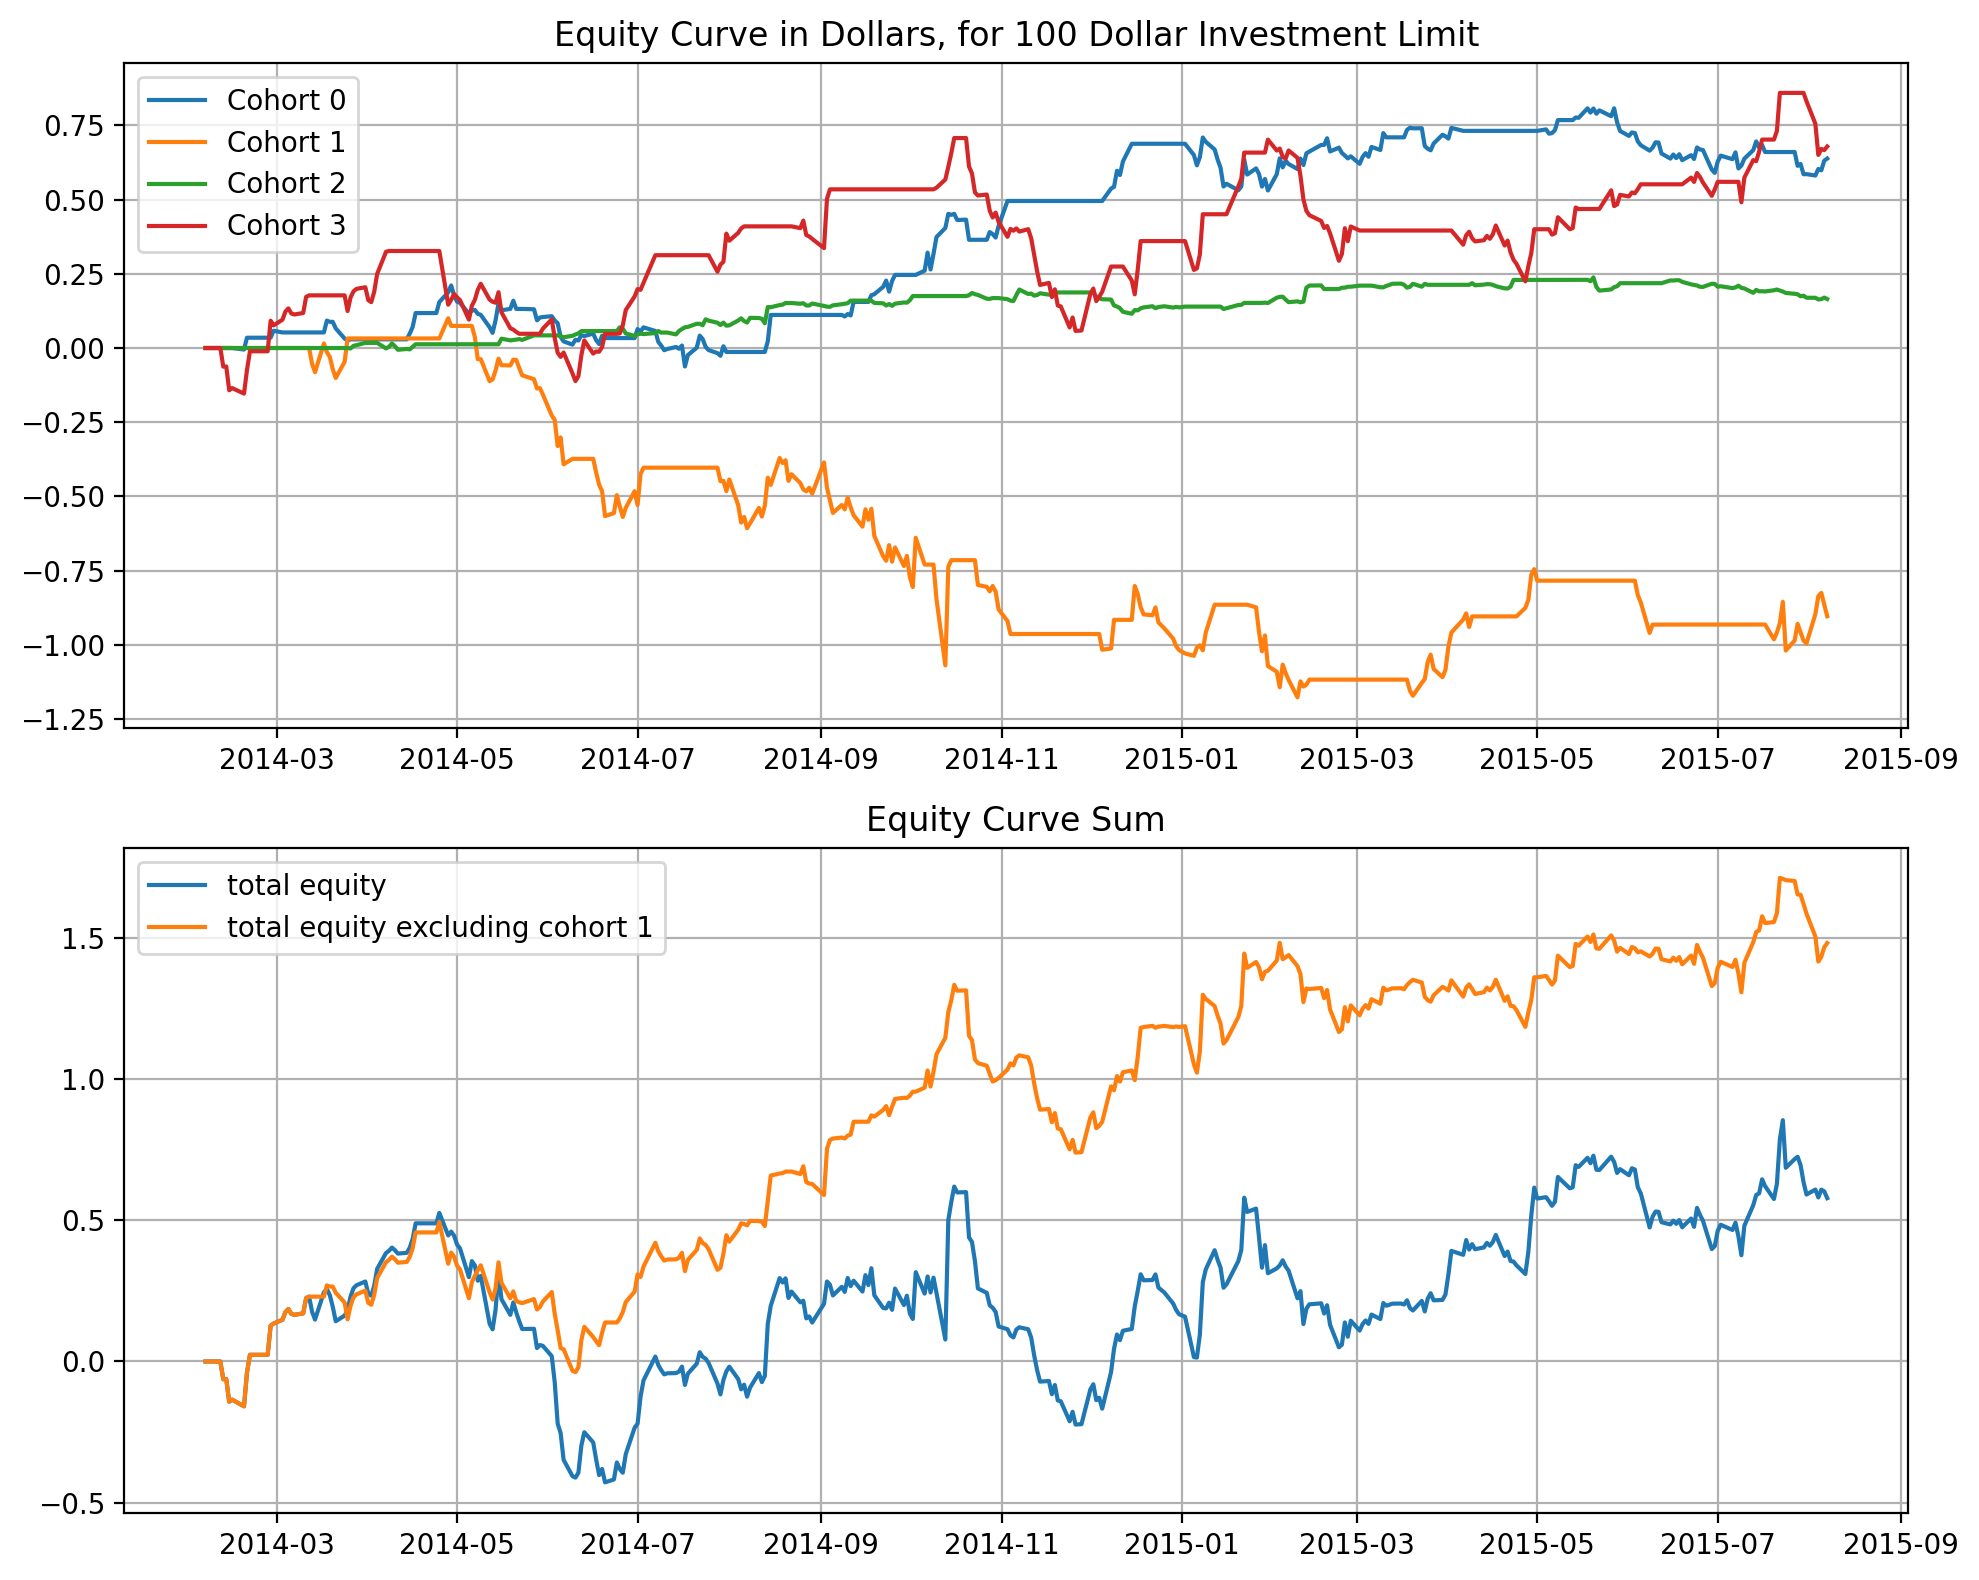

In [13]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]},figsize=(10,8), dpi=200)

axs[0].plot(equity_cohorts[0], label='Cohort 0')
axs[0].plot(equity_cohorts[1], label='Cohort 1')
axs[0].plot(equity_cohorts[2], label='Cohort 2')
axs[0].plot(equity_cohorts[3], label='Cohort 3')
axs[0].legend()
axs[0].grid()
axs[0].set_title('Equity Curve in Dollars, for 100 Dollar Investment Limit')

axs[1].plot(total_equity, label='total equity')
axs[1].plot(total_equity - equity_cohorts[1], label='total equity excluding cohort 1')
axs[1].legend()
axs[1].grid()
axs[1].set_title('Equity Curve Sum')

fig.tight_layout()

plt.show()

## Conclusion
Vine copula provides a very flexible approach in modeling multi-variate dependencies. The C-vine structure specifically highlights a dominant component at every level of the tree, ideal for our “1-vs-the rest” trading strategy for capturing statistical arbitrage among multiple stocks, which non-quant strategies often omit or are still primitive.

As promising as it looks, just like any other methods, it inevitably bears  some minor drawbacks:

1. High start-up cost: to understand this method, the user needs to understand copula modeling from scratch, and also how to interprete vine copula models from end to end.

2. High computation cost: For a cohort of 4 stocks and 3 years of daily training data + 1 year of test data, it takes about 30 seconds to fit and generate positions. This can hardly be optimized further since the fitting algorithm is already written in an optimized C++ library. And the computation time should scale up in O(N!)

This is just for fitting and generating positions without factoring into the time for stocks selection.

Interpretability: Since the exact fitting algorithms are quite complicated, the interpretability may suffer in back tracking possible fitting issues and how to evaluate each fit. Also, the high dimension makes it difficult to produce an intuitive plot just to visually check if the model is correct, unlike bivariate copulas.

## References
- [Stübinger, J., Mangold, B. and Krauss, C., 2018. Statistical arbitrage with vine copulas. Quantitative Finance, 18(11), pp.1831-1849](https://www.tandfonline.com/doi/pdf/10.1080/14697688.2018.1438642?casa_token=olPBPI2bc3IAAAAA:8QViZfM9C0pbxGrarr-BU-yO2Or_wkCF_Pvk4dJFppjNtFzWjfM7W14_oc_ztl_1csHe4gFfloEWyA)
- [Joe, H. and Kurowicka, D. eds., 2011. Dependence modeling: vine copula handbook. World Scientific.](https://www.worldscientific.com/worldscibooks/10.1142/7699)
- [Yu, R., Yang, R., Zhang, C., Špoljar, M., Kuczyńska-Kippen, N. and Sang, G., 2020. A Vine Copula-Based Modeling for Identification of Multivariate Water Pollution Risk in an Interconnected River System Network. Water, 12(10), p.2741.](https://www.mdpi.com/2073-4441/12/10/2741/pdf)
- [Dissmann, J., Brechmann, E.C., Czado, C. and Kurowicka, D., 2013. Selecting and estimating regular vine copulae and application to financial returns. Computational Statistics & Data Analysis, 59, pp.52-69.](https://arxiv.org/pdf/1202.2002)